# Agent 4: Drafter AI Agent

In [1]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage

from langchain_groq import ChatGroq
from langchain_core.tools import tool

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END

from langgraph.prebuilt import ToolNode

load_dotenv()

True

In [2]:
# This is the global variable to store document content
doc_content = ""

In [3]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [4]:
@tool
def update(content:str) -> str:
    """this function upates the content inside the document
    with the new content provided."""
    global doc_content
    
    doc_content = content
    return f"Document has been updated successfully! The current content is:\n{doc_content}"

@tool
def save(filename: str) -> str:
    """this function saves the document to a text file (.txt) 
    and names it a suitable name and finishes the process."""
    global doc_content

    # make sure the file is .txt
    if not filename.endswith('.txt'):
        filename = f"{filename}.txt"


    try:
        with open(filename, 'w') as file:
            file.write(doc_content)
        print(f"\n💾 Document has been saved to: {filename}")
        return f"Document has been saved successfully to '{filename}'."
    
    except Exception as e:
        return f"Error saving document: {str(e)}"
    
tools = [update, save]

In [5]:
model = ChatGroq(model = "openai/gpt-oss-120b").bind_tools(tools)

In [6]:
def our_agent(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.
    
    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.
    
    The current document content is:{doc_content}
    """)

    if not state["messages"]:
        user_input = "I'm ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)

    else:
        user_input = input("\nWhat would you like to do with the document? ")
        print(f"\n👤 USER: {user_input}")
        user_message = HumanMessage(content=user_input)

    all_messages = [system_prompt] + list(state["messages"]) + [user_message]

    response = model.invoke(all_messages)
    
    print(f"\n🤖 AI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": list(state["messages"]) + [user_message, response]}

In [7]:
def should_continue(state:AgentState)-> str:
    """Determine if we should continue or end the conversation."""

    messages = state["messages"]
    
    if not messages:
        return "continue"
    
    # This looks for the most recent tool message....
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        if (isinstance(message, ToolMessage) and 
            "saved" in message.content.lower() and
            "document" in message.content.lower()):
            return "end" # goes to the end edge which leads to the endpoint
        
    return "continue"


In [8]:
def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return
    
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")

In [9]:
graph = StateGraph(AgentState)

graph.add_node("agent", our_agent)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("agent")

graph.add_edge("agent", "tools")


graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "agent",
        "end": END,
    },
)

app = graph.compile()

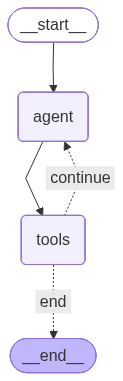

In [10]:
# Visulaize the graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
def run_document_agent():
    print("\n ===== DRAFTER =====")
    
    state = {"messages": []}
    
    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])
    
    print("\n ===== DRAFTER FINISHED =====")

In [ ]:
while 1:
    run_document_agent()


 ===== DRAFTER =====

🤖 AI: Sure! Let’s get started. What kind of document are you working on, and what changes would you like to make? Feel free to share any text you’d like added, removed, or revised. If you’d like to start a brand‑new document, just let me know the topic and any specific sections you have in mind.

👤 USER: write an emalie to my professor telling him i completed the graduation project

🤖 AI: 
🔧 USING TOOLS: ['update']

🛠️ TOOL RESULT: Document has been updated successfully! The current content is:
Subject: Completion of Graduation Project

Dear Professor [Last Name],

I hope you are doing well. I am writing to inform you that I have successfully completed my graduation project titled "[Project Title]". The final report and all related materials are ready for your review.

I would like to thank you for your guidance and support throughout the project. Your insights and feedback have been invaluable in shaping the direction and quality of my work.

Please let me know 